In [64]:
import numpy as np
import matplotlib.pyplot as plt

path = "cache/G_history_samples/N16x16_C20_S100_nshNone_DW1_init-default_n_a0.5_markov_circuit.npz"
data = np.load(path)
G_hist = data[data.files[0]]                   # shape (S, T, Nlayer, Nlayer)
                # final-cycle top-layer covariances
 
 

In [ ]:
S, T, Ntot, _ = G_hist.shape
Nlayer = Ntot//2
G_final = G_hist[:, -1, :Nlayer, :Nlayer]  # shape (Nlayer, Nlayer)
print(G_final.shape)
Nx = Ny = 16


(100, 512, 512)


In [60]:
def as_block(G_flat, Nx, Ny):
    """(Nlayer,Nlayer)->(Nx,Ny,2,Nx,Ny,2), respecting Fortran ordering."""
    G2 = 0.5 * (G_flat + np.eye(G_flat.shape[-1], dtype=np.complex128))
    G6 = G2.reshape(2, Nx, Ny, 2, Nx, Ny, order="F")
    return np.transpose(G6, (1, 2, 0, 4, 5, 3))

def current_maps_gauge_invariant(G_flat, Nx, Ny):
    """
    Gauge-invariant currents extracted from a two-point tensor block:
      block[x, y, μ, x', y', μ′] = ⟨c†_{x,y,μ} c_{x',y',μ′}⟩

    Returns
    -------
    J_x, J_y : arrays of shape (Nx, Ny)
        Gauge-invariant currents flowing along +x and +y bonds.
    """
    block = as_block(G_flat, Nx, Ny)
    x_idx = np.arange(Nx)[:, None]
    y_idx = np.arange(Ny)[None, :]

    x_next = (x_idx + 1) % Nx
    y_next = (y_idx + 1) % Ny

    G11_x = block[x_idx, y_idx, 0, x_next, y_idx, 0]
    G22_x = block[x_idx, y_idx, 1, x_next, y_idx, 1]
    G12_x = block[x_idx, y_idx, 0, x_next, y_idx, 1]

    G11_y = block[x_idx, y_idx, 0, x_idx, y_next, 0]
    G22_y = block[x_idx, y_idx, 1, x_idx, y_next, 1]
    G12_y = block[x_idx, y_idx, 0, x_idx, y_next, 1]

    J_x = np.imag(-G11_x + G22_x + 1j * G12_x)
    J_y = np.imag(-G11_y + G22_y - G12_y)
    return J_x, J_y


J_x, J_y = current_maps_gauge_invariant(G_final, Nx, Ny)

<function matplotlib.pyplot.show(close=None, block=None)>

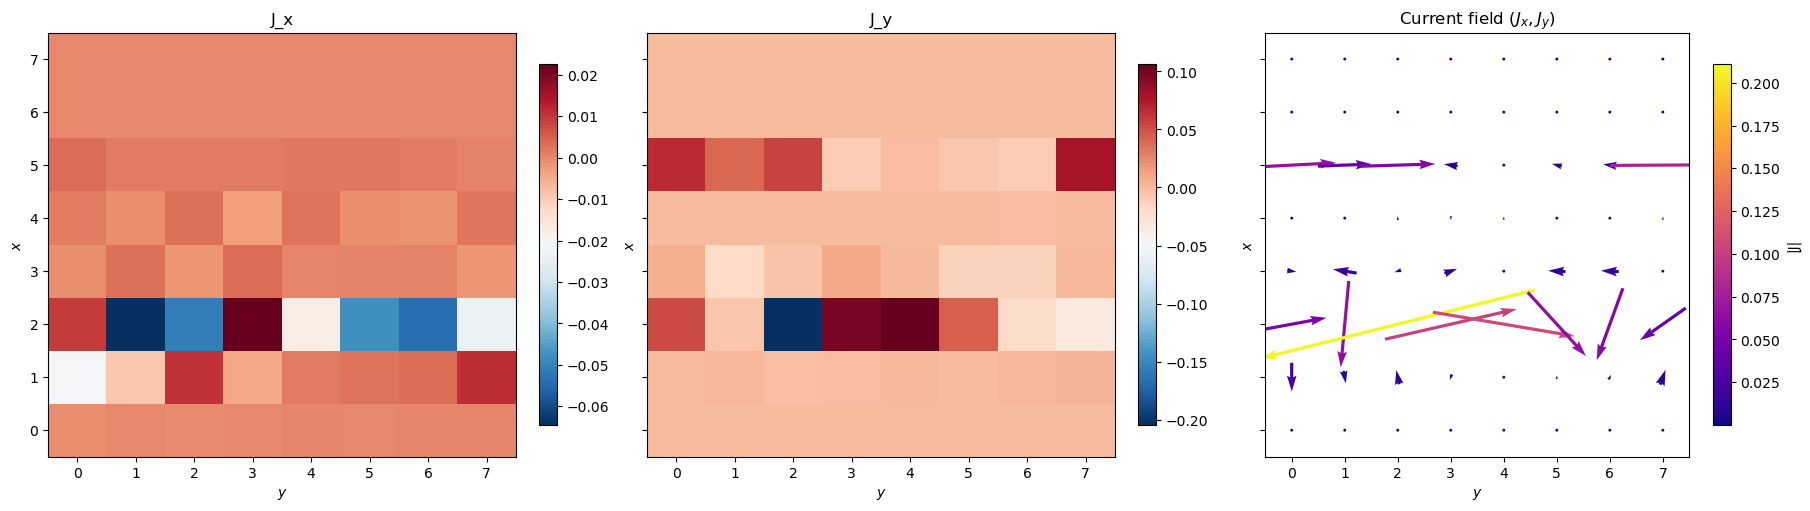

In [61]:
# --- currents and plots ---
extent = (-0.5, J_x.shape[1] - 0.5, -0.5, J_x.shape[0] - 0.5)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, constrained_layout=True)

for ax, (title, data) in zip(axes[:2], [("J_x", J_x), ("J_y", J_y)]):
    im = ax.imshow(
        data,
        origin="lower",
        aspect="auto",
        cmap="RdBu_r",
        extent=extent,
    )
    ax.set_title(title)
    ax.set_xlabel(r"$y$")
    ax.set_ylabel(r"$x$")
    fig.colorbar(im, ax=ax, shrink=0.85)

y_coords, x_coords = np.meshgrid(np.arange(Ny), np.arange(Nx))
magnitude = np.hypot(J_x, J_y)
quiv = axes[2].quiver(
    y_coords,
    x_coords,
    J_y,
    J_x,
    magnitude,
    cmap="plasma",
    angles="xy",
    scale_units="xy",
    scale=None,
    pivot="mid",
)
axes[2].set_xlim(extent[0], extent[1])
axes[2].set_ylim(extent[2], extent[3])
axes[2].set_xlabel(r"$y$")
axes[2].set_ylabel(r"$x$")
axes[2].set_title("Current field $(J_x, J_y)$")
axes[2].set_aspect("equal")
fig.colorbar(quiv, ax=axes[2], shrink=0.85, label="|J|")

plt.show

DWs at x=(2, 5)
------------------------- classA_U1FGTN Initialized -------------------------


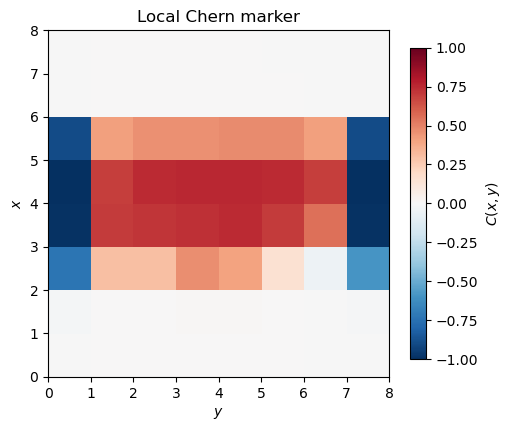

In [62]:
import importlib
import classA_U1FGTN as mod
importlib.reload(mod)
from classA_U1FGTN import classA_U1FGTN

model = classA_U1FGTN(Nx=Nx, Ny=Ny, DW=True, alpha_triv = 30)

chern_map = model.local_chern_marker_flat(G_final)

fig, ax = plt.subplots(figsize=(5.5, 4.5))
im = ax.imshow(
    chern_map,
    origin="lower",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    extent=[0, Ny, 0, Nx],
    aspect="auto",
)
ax.set_xlabel("$y$")
ax.set_ylabel("$x$")
ax.set_title("Local Chern marker")
cbar = fig.colorbar(im, ax=ax, shrink=0.9)
cbar.set_label("$C(x,y)$")
plt.show()


In [67]:
model.plot_corr_y_profiles(G_hist)

ValueError: entanglement_contour_suite expects last dims 256 or 128; got 512

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def cov_to_block(cov, Nx, Ny):
    """Convert a single (Nlayer, Nlayer) covariance to (Nx, Ny, 2, Nx, Ny, 2)."""
    dim = cov.shape[0]
    assert dim == 2 * Nx * Ny, f"Expected dim=2*Nx*Ny, got {dim}"
    G2 = 0.5 * (cov + np.eye(dim, dtype=np.complex128))
    G6 = G2.reshape(2, Nx, Ny, 2, Nx, Ny, order="F")
    return np.transpose(G6, (1, 2, 0, 4, 5, 3))

def current_map_nn(block):
    """Nearest-neighbor current J_{(x,y),(x,y+1)} from a block."""
    Nx, Ny = block.shape[:2]
    x = np.arange(Nx)[:, None]
    y = np.arange(Ny)[None, :]
    diag = block[x, y, :, x, (y + 1) % Ny, :]
    return 0.5 * np.imag(diag.sum(axis=(-1, -2)))

def J_nn_history(cov_hist, Nx, Ny):
    """cov_hist shape: (T, Nlayer, Nlayer) -> (T, Nx, Ny)."""
    return np.array([current_map_nn(cov_to_block(cov, Nx, Ny)) for cov in cov_hist])

# --- user inputs ---
traj_index = 0          # which single trajectory to display
Nx, Ny = 16, 16         # adjust to match your lattice (2 * Nx * Ny = Nlayer)
filename = "J_nn_single_vs_avg.gif"

# --- build J histories ---
G_single = G_hist_top[traj_index]                 # shape (T, Nlayer, Nlayer)
G_avg = G_hist_top.mean(axis=0)                   # trajectory-averaged covariance

J_single = J_nn_history(G_single, Nx, Ny)
J_avg = J_nn_history(G_avg, Nx, Ny)



In [9]:

vmax_single = np.max(np.abs(J_single))
vmax_avg = np.max(np.abs(J_avg))

# --- animate ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False, constrained_layout=True)
im_single = axes[0].imshow(J_single[0], origin="lower", cmap="RdBu_r", vmin=-vmax_single, vmax=vmax_single)
im_avg = axes[1].imshow(J_avg[0], origin="lower", cmap="RdBu_r", vmin=-vmax_avg, vmax=vmax_avg)

axes[0].set_title(fr"Trajectory {traj_index}: $J_{{y,y+1}}$")
axes[1].set_title(r"Trajectory-averaged $J_{y,y+1}$")
for ax in axes:
    ax.set_xlabel("$y$")
axes[0].set_ylabel("$x$")
fig.colorbar(im_single, ax=axes[0], shrink=0.8)
fig.colorbar(im_avg, ax=axes[1], shrink=0.8)

def update(frame):
    im_single.set_data(J_single[frame])
    im_avg.set_data(J_avg[frame])
    fig.suptitle(f"Cycle {frame}")
    return im_single, im_avg

anim = FuncAnimation(fig, update, frames=J_single.shape[0], interval=200, blit=False)
anim.save(filename, writer=PillowWriter(fps=5))
plt.close(fig)
